In [3]:
from neuronet import ActivePerceptron
from deductor_parser import DeductorParser
from optimizer import OptimizerDE

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

In [6]:
parser = DeductorParser('диафрагменный электролиз.ded')

In [7]:
# parser.getdocumentsxml().keys()

In [8]:
parser.setdocument('Данные.csv')

In [9]:
# parser.getneuronetssxml().keys()

In [10]:
parser.setneuronet(r'Нейросеть [7 x 31 x 6]', parse=True)
# parser.setneuronet(r'Нейросеть [7 x 86 x 86 x 6]', parse=True)
# parser.setneuronet(r'Нейросеть [7 x 653 x 6]', parse=True)

# 0.00180652809185921 0.0155840683283965
# 0.00177769163925731 0.0152678161918611
# 0.00285182685301558 0.0148743399993834

nw = ActivePerceptron()
nw.loader(parser.neurodata)
model = nw

In [11]:
# Интервалы вариации

#intervals = parser.neurodata['inp_norm']
intervals = [
    [20, 180],  # Q_rass
    [42, 48],   # T_rass
    [305, 315], # C_NaCl
    [80, 84],   # T_analit
    [48, 62.5], # I
    [0, 3.55],  # E
    [0, 1]      # zad
]

in_intervals = [
    [20, 180],  # Q_rass
    [42, 48],   # T_rass
    [305, 315], # C_NaCl
    [80, 84],   # T_analit
    [48, 62.5], # I
    [0, 3.55],  # E
    [0, 1]      # zad
]

In [12]:
# Выходные интервалы

out_intervals = [
    [0, 1],      # Vyh
    [80, 140],   # C_NaOH
    [88, 100],   # C_Cl2_Cl2
    [0, 0.5],    # C_H2_Cl2
    [97.5, 100], # C_H2_H2
    [0, 0.4]     # C_O2_H2
]

out_hard_intervals = [
    [0, float('inf')], # Vyh
    [0, 200],          # C_NaOH
    [88, 100],         # C_Cl2_Cl2
    [0, 0.5],          # C_H2_Cl2
    [97.5, 100],       # C_H2_H2
    [0, 0.4]           # C_O2_H2
]

def check_out_intervals(y):
    return all(out_hard_intervals[i][0] <= y[i] <= out_hard_intervals[i][1] for i in range(len(y)))

In [13]:
# Оптимизирующий функционал

def otklonenie(val, interval):
    medium = sum(interval) / 2
    return (2 * (val - medium) / (interval[1] - interval[0])) ** 2


def otklonenie_to_min(val, interval):
    return ((val - min(interval)) / (interval[1] - interval[0])) ** 2


def otklonenie_to_max(val, interval):
    return ((max(interval) - val) / (interval[1] - interval[0])) ** 2


def func(x, y):
    coeffs = [1 / len(y)] * len(y)
    coeffs_x = [1 / len(x)] * len(x)
    regular = 1.0
    
    err = 0
    # 0 - выход
    i = 0
    err += coeffs[i] * otklonenie_to_max(y[i], out_intervals[i])
    # 1 - концентрация NaOH в электрощелоках
    i = 1
    err += coeffs[i] * otklonenie(y[i], out_intervals[i])
    # 2 - концентрация Cl2 в хлоргазе
    i = 2
    err += coeffs[i] * otklonenie_to_max(y[i], out_intervals[i])
    # 3 - концентрация H2 в хлоргазе
    i = 3
    err += coeffs[i] * otklonenie_to_min(y[i], out_intervals[i])
    # 4 - концентрация H2 в водороде
    i = 4
    err += coeffs[i] * otklonenie_to_max(y[i], out_intervals[i])
    # 5 - концентрация O2 в водороде
    i = 5
    err += coeffs[i] * otklonenie_to_min(y[i], out_intervals[i])
    
    err_x = 0
    for i in range(len(x)):
        err_x += coeffs_x[i] * otklonenie(x[i], in_intervals[i])

    return err + regular * err_x

In [14]:
# Оптимизатор по алгоритму "дифференциальная эволюция"

opt = OptimizerDE()

In [15]:
# Задаем математическую модель
opt.model = model
# Задаем минимизирующий функционал
opt.func = func
# Интервалы варации
opt.intervals = intervals
# Начальный диапазон поиска. 1 - весь диапазон
opt.full_width_variation(1, count=len(in_intervals))
# Все входные параметры - вариативные
opt.var = [True] * 7
# Ограничение эпох - включено
opt.epoches = True
# Лимит эпох
opt.epoches_limit = 1000
# Минимизация
opt.maximization = False
# Печать логов - включена
opt.print_log = True
# Ограничение на количество холостых эпох - включено
opt.idle = True
# Лимит холостых эпох
opt.idle_limit = 100
# Ограничение по точности
opt.tol = False
# Точность
opt.tol_limit = 0.001

In [16]:
# Коэффициент мутантности, от 0 до 2
opt.coeff_f = 1
# Коэффициент кроссинговера, от 0 до 1
opt.coeff_d = 0.5

In [17]:
# Создание популиции векторов

opt.initialize_random(40)

[[24.50909948459382, 42.07622720422034, 305, 81.39640702759229, 50.850079378159045, 1.5307558518750983, 0], [114.55869346047467, 45.2466768018523, 305, 83.71150248750608, 54.72601778865633, 0, 0.6192700426296576], [123.01606027813013, 46.67532882571698, 305, 80, 51.94067467892862, 0, 0.31188367461752087], [97.41117389263081, 42, 305.21498850219183, 81.45250422038623, 54.58399547162798, 0.08938377452220281, 0.6720253279676801], [159.94108129771882, 45.839833214234496, 308.40928271300123, 83.49799305373357, 52.49696650108072, 3.1449986998765453, 0.6543377333654185], [20, 43.6696984945147, 315, 80, 53.33597269366832, 1.7377827049986199, 0], [121.15369340243312, 42, 308.8089184176699, 81.38357738322033, 62.5, 1.6466064877428523, 0.5976857579428149], [180, 45.677582432880264, 312.0397558557428, 81.92461879186885, 48.030295830822546, 0.48435369889338165, 0.7574455463018396], [20, 45.7968246768111, 313.25973581326014, 82.05079220635287, 55.446876040990595, 2.475984106025863, 0.897545909480158

In [18]:
opt.limits_out.append(check_out_intervals)

In [19]:
opt.limits_out.append(lambda y: y[2] + y[3] <= 100)

In [20]:
opt.limits_out.append(lambda y: y[4] + y[5] <= 100)

In [21]:
opt.reset(reset_trands=True)

In [22]:
opt.start()

step: 1	error: 281.2578892110768
input: [24.50909948459382, 42.07622720422034, 305, 81.39640702759229, 50.850079378159045, 1.5307558518750983, 0]
output: [0.0004971241922169001, 0.08472584401379758, 0.012489814695515064, 0.0001852895787277864, 0.0001303363935313851, 0.00024077973241572382]

step: 2	error: 281.2578892110768
input: [24.50909948459382, 42.07622720422034, 305, 81.39640702759229, 50.850079378159045, 1.5307558518750983, 0]
output: [0.0004971241922169001, 0.08472584401379758, 0.012489814695515064, 0.0001852895787277864, 0.0001303363935313851, 0.00024077973241572382]

step: 3	error: 1.234808646100282
input: [55.466626839342666, 48, 309.6516555566502, 84, 62.136772748900455, 0.3980917620519726, 0.9659323683972036]
output: [0.9482582143583993, 161.01329448847386, 97.28692722972038, 0.0308295055918236, 98.38807269817566, 0.06505959359966124]

step: 4	error: 1.049458369775596
input: [64.45494614044618, 48, 305, 80.27014208030194, 59.16926207648263, 0.9013572636393774, 1]
output: [


step: 49	error: 0.6258457782423423
input: [61.30238059608678, 47.119782365457844, 309.38573073654385, 81.99790327240706, 56.10813669815643, 0.7889288539029851, 1]
output: [0.9421570284444795, 139.07097679306685, 96.53238920928982, 0.02993134492386066, 97.59272709634398, 0.061054482361228526]

step: 50	error: 0.6258457782423423
input: [61.30238059608678, 47.119782365457844, 309.38573073654385, 81.99790327240706, 56.10813669815643, 0.7889288539029851, 1]
output: [0.9421570284444795, 139.07097679306685, 96.53238920928982, 0.02993134492386066, 97.59272709634398, 0.061054482361228526]

step: 51	error: 0.6258457782423423
input: [61.30238059608678, 47.119782365457844, 309.38573073654385, 81.99790327240706, 56.10813669815643, 0.7889288539029851, 1]
output: [0.9421570284444795, 139.07097679306685, 96.53238920928982, 0.02993134492386066, 97.59272709634398, 0.061054482361228526]

step: 52	error: 0.6258457782423423
input: [61.30238059608678, 47.119782365457844, 309.38573073654385, 81.997903272407

step: 93	error: 0.6071354222945773
input: [83.45640378950473, 46.854040813969014, 308.3155161611809, 81.76207163017892, 57.184949198624345, 1.0078038290293534, 1]
output: [0.942003471633533, 139.8821209908483, 96.40006709644577, 0.02983254976035409, 97.52669358145725, 0.06092842110952566]

step: 94	error: 0.6071354222945773
input: [83.45640378950473, 46.854040813969014, 308.3155161611809, 81.76207163017892, 57.184949198624345, 1.0078038290293534, 1]
output: [0.942003471633533, 139.8821209908483, 96.40006709644577, 0.02983254976035409, 97.52669358145725, 0.06092842110952566]

step: 95	error: 0.6071354222945773
input: [83.45640378950473, 46.854040813969014, 308.3155161611809, 81.76207163017892, 57.184949198624345, 1.0078038290293534, 1]
output: [0.942003471633533, 139.8821209908483, 96.40006709644577, 0.02983254976035409, 97.52669358145725, 0.06092842110952566]

step: 96	error: 0.6071354222945773
input: [83.45640378950473, 46.854040813969014, 308.3155161611809, 81.76207163017892, 57.1849

step: 126	error: 0.6071354222945773
input: [83.45640378950473, 46.854040813969014, 308.3155161611809, 81.76207163017892, 57.184949198624345, 1.0078038290293534, 1]
output: [0.942003471633533, 139.8821209908483, 96.40006709644577, 0.02983254976035409, 97.52669358145725, 0.06092842110952566]

step: 127	error: 0.6071354222945773
input: [83.45640378950473, 46.854040813969014, 308.3155161611809, 81.76207163017892, 57.184949198624345, 1.0078038290293534, 1]
output: [0.942003471633533, 139.8821209908483, 96.40006709644577, 0.02983254976035409, 97.52669358145725, 0.06092842110952566]

step: 128	error: 0.6071354222945773
input: [83.45640378950473, 46.854040813969014, 308.3155161611809, 81.76207163017892, 57.184949198624345, 1.0078038290293534, 1]
output: [0.942003471633533, 139.8821209908483, 96.40006709644577, 0.02983254976035409, 97.52669358145725, 0.06092842110952566]

step: 129	error: 0.6071354222945773
input: [83.45640378950473, 46.854040813969014, 308.3155161611809, 81.76207163017892, 57.

In [23]:
# Сохранить состояние

opt.save()

In [24]:
# Оптимальные входные параметры

for i in range(len(opt.val)):
    print(parser.neurodata['inp_names'][i], opt.val[i], sep=':\t\t')

Q_rass:		83.45640378950473
T_rass:		46.854040813969014
C_NaCl:		308.3155161611809
T_analit:		81.76207163017892
I:		57.184949198624345
E:		1.0078038290293534
zad:		1


In [25]:
# Оптимальные выходные параметры
out_names = ['Vyh', 'C_NaOH', 'C_Cl2_Cl2', 'C_H2_Cl2', 'C_H2_H2', 'C_O2_H2']

for i in range(len(opt.out)):
    print(out_names[i], opt.out[i], sep=':\t\t')

Vyh:		0.942003471633533
C_NaOH:		139.8821209908483
C_Cl2_Cl2:		96.40006709644577
C_H2_Cl2:		0.02983254976035409
C_H2_H2:		97.52669358145725
C_O2_H2:		0.06092842110952566


In [26]:
# Значение оптимизирующего функционала в точке оптимума

print(opt.error)

0.6071354222945773


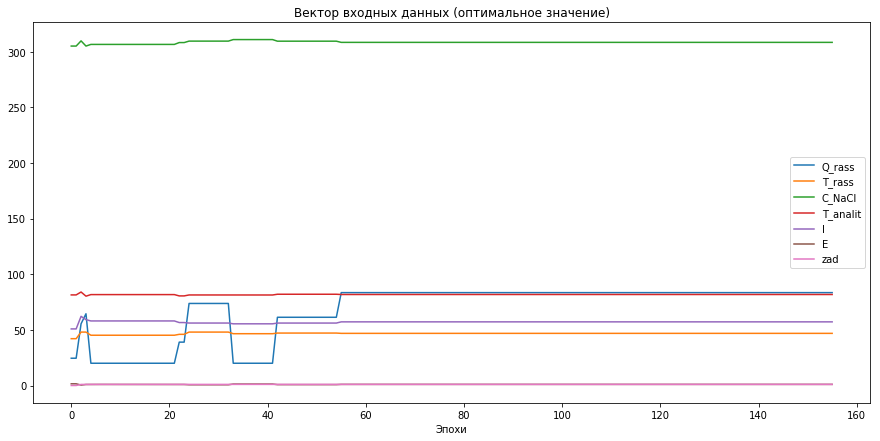

In [27]:
plt.plot(range(len(opt.trands['opt_x'])), opt.trands['opt_x'])
plt.legend(parser.neurodata['inp_names'])
plt.title('Вектор входных данных (оптимальное значение)')
plt.xlabel('Эпохи')
plt.show()

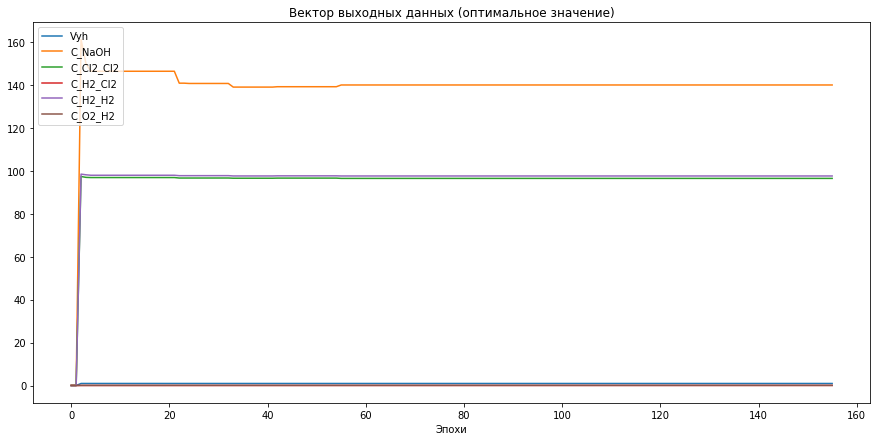

In [28]:
plt.plot(range(len(opt.trands['opt_y'])), opt.trands['opt_y'])
plt.legend(out_names)
plt.title('Вектор выходных данных (оптимальное значение)')
plt.xlabel('Эпохи')
plt.show()

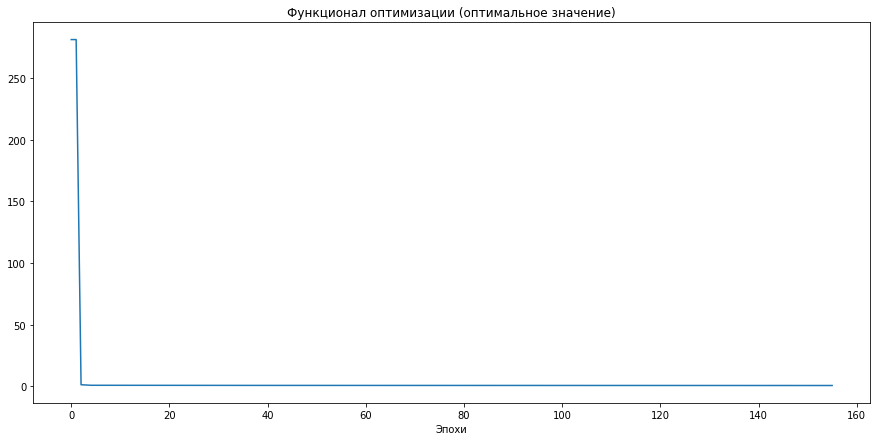

In [29]:
plt.plot(range(len(opt.trands['opt_e'])), opt.trands['opt_e'])
plt.title('Функционал оптимизации (оптимальное значение)')
plt.xlabel('Эпохи')
plt.show()